In [1]:
import os, sys
import importlib
import torch

import numpy as np

from utils import load, vis

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
importlib.reload(vis)

data_folder = "data/simplified/"
access_file_generator = map(lambda x : data_folder + x + '.csv', load.classes)
trainGenerator = vis.ImageGenerator(access_file_generator)

In [3]:
gen = trainGenerator.generateImages()

X.shape: (128, 64, 64, 4)
y.shape: (128, 8)


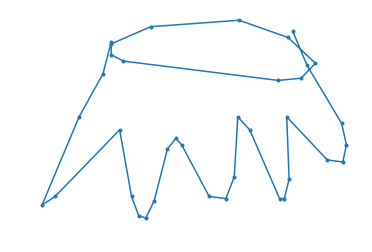

In [4]:
%matplotlib inline
X, y = next(gen)
print('X.shape:', X.shape)
print('y.shape:', y.shape)

array([0., 0., 0., 0., 0., 1., 0., 0.])

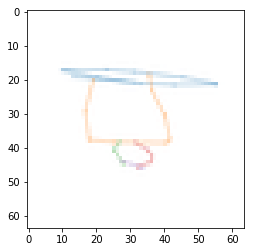

In [5]:
import matplotlib.pyplot as plt
plt.imshow(X[0].astype(int))
y[0]

# Building PyTorch CNN Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as ag
import torch.optim as optim


class LeNet(nn.Module):
    # Here we define our network structure
    def __init__(self, cdim=8):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(4, 6, 3).double() 
        self.conv2 = nn.Conv2d(6,16, 3).double()
        self.conv3 = nn.Conv2d(16,32,3).double()
        self.conv4 = nn.Conv2d(32,64,3).double()
        self.fc1   = nn.Linear(256,128).double()
        self.fc2   = nn.Linear(128, 84).double() 
        self.fc3   = nn.Linear(84,cdim).double()
        
    # Here we define one forward pass through the network
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        x = x.view(-1, int(self.num_flat_features(x)))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    # Determine the number of features in a batch of tensors
    def num_flat_features(self, x): 
        size = x.size()
        return np.prod(size[1:])


net = LeNet(cdim=y.shape[1])

In [7]:
xtest = ag.Variable(torch.from_numpy(np.moveaxis(X, [-1], [1])), requires_grad=False)
ypred = net(xtest)
acc   = 100 * np.mean(np.argmax(y,1) == ypred.data.numpy().T.argmax(axis=0))
print('Classification Accuracy on Initialized LeNet = {0:.3}%'.format(acc))

Classification Accuracy on Initialized LeNet = 12.5%


In [8]:
B     = 128              # Minibatch size
T     = 10               # Number of epochs
gamma = .001             # learning rate
rho   = .9               # momentum

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    net.parameters(),
    lr=gamma,
    momentum=rho
)

In [ ]:
if torch.cuda.is_available():
    net = net.cuda()

    
accList, lossList = list(), list()
for epoch in range(T):
    running_loss, k   = 0.0, 0
    for X,y in trainGenerator.generateImages():
        inputs = ag.Variable(torch.from_numpy(np.moveaxis(X, [-1], [1])), requires_grad=False)
        labels = ag.Variable(torch.from_numpy(np.argmax(y, 1)), requires_grad=False)
        
        if torch.cuda.is_available():
            inputs  = inputs.cuda()
            labels  = labels.cuda()
        
        # Initialize the gradiaent to zero
        optimizer.zero_grad()
        output = net(inputs)
        loss   = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss[0]
        k += 1
        if k % 10 == 9:
            ypred = net(inputs)
            acc   = 100 * np.mean(np.argmax(y,1) == ypred.data.numpy().T.argmax(axis=0))
            print('[%d, %5d] loss: %.3f\t acc: %.1f' % (epoch + 1, k + 1, running_loss/10, acc))
            accList.append(acc)
            lossList.append(running_loss/10)
            running_loss = 0.0
            

print('Finished Training')

[1,    10] loss: 1.929	 acc: 19.5
[1,    20] loss: 2.054	 acc: 21.9
[1,    30] loss: 1.997	 acc: 28.1
[1,    40] loss: 1.940	 acc: 36.7
[1,    50] loss: 1.833	 acc: 39.1
[1,    60] loss: 1.700	 acc: 37.5
[1,    70] loss: 1.566	 acc: 45.3
[1,    80] loss: 1.444	 acc: 60.9
[1,    90] loss: 1.318	 acc: 50.0
[1,   100] loss: 1.329	 acc: 53.1
[1,   110] loss: 1.296	 acc: 62.5
[1,   120] loss: 1.173	 acc: 56.2
[1,   130] loss: 1.171	 acc: 64.8
[1,   140] loss: 1.056	 acc: 70.3
[1,   150] loss: 1.016	 acc: 65.6
[1,   160] loss: 1.038	 acc: 60.9
[1,   170] loss: 0.963	 acc: 75.8
[1,   180] loss: 0.934	 acc: 62.5
[1,   190] loss: 0.976	 acc: 66.4
[1,   200] loss: 0.976	 acc: 74.2
[1,   210] loss: 0.932	 acc: 69.5
[1,   220] loss: 0.940	 acc: 65.6
[1,   230] loss: 0.931	 acc: 71.9
[1,   240] loss: 0.869	 acc: 76.6
[1,   250] loss: 0.858	 acc: 73.4
[1,   260] loss: 0.861	 acc: 76.6
[1,   270] loss: 0.885	 acc: 75.8
